# Colorização Automática de Imagens em Tons de Cinza via Classificação Multimodal

#### O objetivo deste notebook é implementar um algoritmo de Deep Learning para a disciplina de Processamento de Imagens, seguindo a referência e embasamento teórico encontrado em http://richzhang.github.io/colorization/

##### https://arxiv.org/pdf/1603.08511

### Dependências

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # Para preprocess_colors
import warnings

warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
IMG_SIZE = 256


**Descrição:** Define uma classe `DogColorizationDataset` personalizada, que herda de `torch.utils.data.Dataset`. Esta classe é responsável por:
- Localizar os caminhos das imagens em um diretório raiz.
- Aplicar transformações às imagens (redimensionamento e inversão horizontal aleatória).
- No método `__getitem__`, carregar uma imagem, convertê-la para o espaço de cor Lab, normalizar os canais L e `ab`, e retorná-los como tensores PyTorch. Os tensores são retornados na CPU.

In [2]:
class DogColorizationDataset(Dataset):
    def __init__(self, root_dir):
        self.root = root_dir
        try:
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if not self.image_paths:
                print(f"Aviso: Nenhum arquivo de imagem encontrado em {root_dir} com as extensões .jpg, .png, .jpeg. O dataset estará vazio.")
        except FileNotFoundError:
            print(f"Erro: Diretório do dataset não encontrado: {root_dir}. O dataset estará vazio.")
            self.image_paths = []

        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            rgb_img = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception as e:
            print(f"Erro ao carregar imagem {self.image_paths[idx]}: {e}. Retornando tensor placeholder na CPU.")
            L_placeholder = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            ab_placeholder = torch.zeros((2, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            # REMOVIDO .to(DEVICE) daqui
            return L_placeholder, ab_placeholder

        rgb_img_transformed = self.transform(rgb_img)
        lab_img = color.rgb2lab(np.array(rgb_img_transformed)).astype(np.float32)
        L = lab_img[:,:,0] / 50.0 - 1.0
        ab = lab_img[:,:,1:] / 128.0

        return (
            torch.FloatTensor(L).unsqueeze(0),
            torch.FloatTensor(ab).permute(2,0,1)
        )


**Descrição:** Define a função `preprocess_colors` que realiza o pré-processamento necessário para a quantização de cores e cálculo dos pesos de rebalanceamento de classes. Especificamente:
- Cria um conjunto de bins candidatos no espaço de cor `ab`.
- Filtra esses bins para manter apenas aqueles que estão dentro da gama RGB (in-gamut) para um valor de L=50, salvando o resultado em `data/ab_bins.npy`. O número de bins válidos (`current_Q`) é determinado dinamicamente.
- Itera sobre o `DogColorizationDataset` para calcular um histograma da frequência de ocorrência de cada bin `ab` no dataset de treinamento.
- Suaviza o histograma empírico usando um kernel Gaussiano.
- Calcula os pesos de rebalanceamento de classes com base na raridade dos bins de cor (conforme o artigo de Zhang et al., 2016) e os salva em `data/color_weights.pt`.
- A função pode pular o recálculo se os arquivos `ab_bins.npy` e `color_weights.pt` já existirem e `force_recompute` for `False`.

In [3]:
def preprocess_colors(data_train_path='data/train', force_recompute=False):
    os.makedirs('data', exist_ok=True)
    ab_bins_path = 'data/ab_bins.npy'
    color_weights_path = 'data/color_weights.pt'

    if not force_recompute and os.path.exists(ab_bins_path) and os.path.exists(color_weights_path):
        print("Arquivos ab_bins.npy e color_weights.pt já existem. Pulando pré-processamento.")
        return

    print("Iniciando pré-processamento de cores...")
    grid_step = 10
    min_ab, max_ab = -110, 110
    axis_values = np.arange(min_ab, max_ab + grid_step, grid_step)
    ab_candidate_bins_x, ab_candidate_bins_y = np.meshgrid(axis_values, axis_values)
    ab_candidate_bins = np.stack((ab_candidate_bins_x.flatten(), ab_candidate_bins_y.flatten()), axis=-1).astype(np.float32)

    valid_bins_list = []
    for a_val, b_val in ab_candidate_bins:
        lab_pixel = np.array([[[50.0, a_val, b_val]]], dtype=np.float32)
        try:
            rgb_pixel = color.lab2rgb(lab_pixel)
            if np.all(rgb_pixel >= 0) and np.all(rgb_pixel <= 1):
                valid_bins_list.append([a_val, b_val])
        except Exception:
            pass

    ab_bins_final = np.array(valid_bins_list, dtype=np.float32)
    if len(ab_bins_final) == 0:
        raise ValueError("Nenhum bin 'ab' válido encontrado. Verifique os parâmetros de quantização.")
    np.save(ab_bins_path, ab_bins_final)
    current_Q = len(ab_bins_final)
    print(f"Salvo {ab_bins_path} com Q = {current_Q} bins. (O artigo menciona Q=313)")

    print(f"Calculando distribuição de pesos de cor a partir de '{data_train_path}'...")
    dataset_for_hist_calc = DogColorizationDataset(data_train_path)

    if len(dataset_for_hist_calc) == 0:
        print("Aviso: Dataset de treinamento para histograma está vazio. Gerando pesos uniformes.")
        p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q) # Evita divisão por zero se current_Q for 0, igual na função RELU
    else:
        hist = np.zeros(current_Q, dtype=np.int64)
        num_processed_pixels = 0

        for i, (L_channel_sample, ab_channels_sample_normalized) in enumerate(dataset_for_hist_calc):
            # ab_channels_sample_normalized agora está na CPU.
            # A verificação do placeholder também usará tensores na CPU.
            placeholder_for_comparison_cpu = torch.zeros((2, IMG_SIZE, IMG_SIZE), dtype=torch.float32) # Criado na CPU

            if ab_channels_sample_normalized.numel() == 0 or \
               (IMG_SIZE > 0 and torch.equal(ab_channels_sample_normalized, placeholder_for_comparison_cpu)):
                if ab_channels_sample_normalized.numel() > 0 :
                     print(f"  Aviso: Pulando amostra placeholder {i+1}/{len(dataset_for_hist_calc)} (provavelmente erro de carregamento de imagem).")
                continue
            
            # redundante? ponto a reavaliar
            single_sample_ab_denormalized_np = ab_channels_sample_normalized.cpu().numpy() * 128.0
            single_sample_ab_transposed_np = single_sample_ab_denormalized_np.transpose(1, 2, 0)
            pixels_ab_pairs = single_sample_ab_transposed_np.reshape(-1, 2)
            num_processed_pixels += pixels_ab_pairs.shape[0]

            if pixels_ab_pairs.shape[0] > 0:
                distances_to_bins = cdist(pixels_ab_pairs, ab_bins_final, metric='euclidean')
                nearest_bin_indices = np.argmin(distances_to_bins, axis=1)
                hist += np.bincount(nearest_bin_indices, minlength=current_Q)
            
            if (i + 1) % 10 == 0 or (i+1) == len(dataset_for_hist_calc):
                print(f"  Processada imagem {i+1}/{len(dataset_for_hist_calc)} para histograma.")

        if num_processed_pixels == 0 or hist.sum() == 0:
            print("Aviso: Nenhum pixel processado ou histograma de cores vazio. Usando pesos uniformes.")
            p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q)
        else:
            p_empirical = hist.astype(np.float32) / hist.sum()
            sigma_smooth = 5.0
            p_smooth = np.zeros_like(p_empirical, dtype=np.float32)
            for q_idx in range(current_Q):
                distances_from_q = np.linalg.norm(ab_bins_final - ab_bins_final[q_idx], axis=1)
                gaussian_kernel_values = np.exp(-distances_from_q**2 / (2 * sigma_smooth**2))
                p_smooth[q_idx] = np.sum(p_empirical * gaussian_kernel_values)

            if p_smooth.sum() < 1e-9:
                 print("Aviso: Distribuição de probabilidade suavizada (p_smooth) é zero. Usando pesos uniformes.")
                 p_smooth = np.ones(current_Q, dtype=np.float32) / max(1, current_Q)
            else:
                p_smooth = p_smooth / p_smooth.sum()

    lambda_rebalance = 0.5
    denominator = (1 - lambda_rebalance) * p_smooth + (lambda_rebalance / max(1, current_Q))
    weights = 1.0 / np.maximum(denominator, 1e-9)
    expected_w = np.sum(p_smooth * weights)
    if abs(expected_w) < 1e-9:
        print("Aviso: E[w] é próximo de zero. Pesos podem não estar normalizados corretamente.")
    else:
        weights = weights / expected_w

    torch.save(torch.FloatTensor(weights), color_weights_path)
    print(f"Salvo {color_weights_path}.")
    print("Pré-processamento de cores concluído.")

**Descrição:** Define a arquitetura da rede neural `ColorNet`, que herda de `torch.nn.Module`.
- A arquitetura é um modelo do tipo U-Net, consistindo em:
    - Blocos encoder (`enc1`, `enc2`, `enc3`) que usam convoluções para reduzir a resolução espacial e aumentar o número de canais.
    - Um bloco intermediário (`mid`) com convoluções dilatadas para aumentar o campo receptivo.
    - Blocos decoder (`dec1`, `dec2`, `dec3`) que usam `Upsample` (interpolação bilinear) e convoluções para aumentar a resolução espacial e diminuir o número de canais.
    - Uma camada convolucional final (`final_conv`) que produz `num_color_bins_q` (Q) canais, correspondendo aos logits para cada bin de cor quantizado.
- O método `forward` define a passagem dos dados através da rede, recebendo o canal L da imagem como entrada e retornando os logits.

In [4]:
class ColorNet(nn.Module):
    def __init__(self, num_color_bins_q):
        super().__init__()
        self.q_val = num_color_bins_q

        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(64)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(128)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(256)
        )
        self.mid = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.final_conv = nn.Conv2d(64, self.q_val, kernel_size=3, padding=1)

    def forward(self, x_l_channel):
        enc1_out = self.enc1(x_l_channel)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        mid_out = self.mid(enc3_out)
        dec1_out = self.dec1(mid_out)
        dec2_out = self.dec2(dec1_out)
        dec3_out = self.dec3(dec2_out)
        output_logits = self.final_conv(dec3_out)
        return output_logits

**Descrição:** Define a classe `ColorLoss` para calcular a função de perda personalizada, baseada no artigo de Zhang et al. (2016).
- No construtor, carrega os centros dos bins `ab` (`ab_bins.npy`) e os pesos de rebalanceamento de classes (`color_weights.pt`) previamente calculados por `preprocess_colors`.
- O método `_soft_encode_ab_channels_chunked` implementa o "soft-encoding": para cada pixel da imagem de entrada, encontra os 5 bins `ab` mais próximos e atribui pesos a eles usando um kernel Gaussiano, gerando uma distribuição de probabilidade alvo suave ($Z_{ground\_truth\_soft}$). Esta operação é feita em "chunks" (amostra por amostra do batch) para gerenciar o uso de memória da GPU.
- O método `forward` calcula a perda:
    1. Denormaliza os canais `ab` verdadeiros.
    2. Obtém a distribuição alvo suave $Z_{ground\_truth\_soft}$ usando `_soft_encode_ab_channels_chunked`.
    3. Calcula os logaritmos das probabilidades preditas pela rede ($\log(\hat{Z}_{predicted})$) usando `F.log_softmax`.
    4. Calcula a perda de entropia cruzada por pixel: $-\sum_q Z_{ground\_truth\_soft} \cdot \log(\hat{Z}_{predicted})$.
    5. Aplica os pesos de rebalanceamento (`class_rebal_weights`) com base no bin de cor $q^*$ mais próximo ao valor `ab` original do pixel (também calculado em "chunks").
    6. Retorna a média da perda ponderada sobre todos os pixels e amostras do batch.

In [5]:
class ColorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            self.ab_bins = torch.from_numpy(np.load('data/ab_bins.npy')).float()
            self.class_rebal_weights = torch.load('data/color_weights.pt').float()
            self.q_val = len(self.ab_bins)
            if self.q_val != len(self.class_rebal_weights):
                raise ValueError("Incompatibilidade entre o número de ab_bins e class_rebal_weights.")
            self.sigma_soft_encode = 5.0
            self.internal_tensors_device = None 
        except FileNotFoundError as e:
            raise FileNotFoundError(
                f"Erro: {e}. 'ab_bins.npy' ou 'color_weights.pt' não encontrado. "
                "Execute preprocess_colors() primeiro."
            ) from e

    def _move_internal_tensors_to_device(self, target_device):
        if self.internal_tensors_device != target_device:
            self.ab_bins = self.ab_bins.to(target_device)
            self.class_rebal_weights = self.class_rebal_weights.to(target_device)
            self.internal_tensors_device = target_device

    def _soft_encode_ab_channels_chunked(self, ab_true_denormalized_batch, target_device): # Renomeado para clareza
        N, _, H, W = ab_true_denormalized_batch.shape
        
        all_Z_soft_encoded_flat_samples = []
        # Processar cada amostra do batch individualmente para reduzir memória do cdist para rodar localmente
        for i in range(N):
            sample_ab_denormalized = ab_true_denormalized_batch[i] # Forma (2, H, W)
            sample_ab_flat_pixels = sample_ab_denormalized.permute(1, 2, 0).reshape(H * W, 2)
            
            pixel_to_bin_distances_sample = torch.cdist(sample_ab_flat_pixels, self.ab_bins)
            
            knn_distances, knn_indices = torch.topk(pixel_to_bin_distances_sample, k=5, dim=1, largest=False)
            knn_gaussian_weights = torch.exp(-knn_distances**2 / (2 * self.sigma_soft_encode**2))
            # Adicionado clamp(min=1e-8) para evitar divisão por zero se todos os pesos forem zero
            knn_weights_normalized = knn_gaussian_weights / torch.sum(knn_gaussian_weights, dim=1, keepdim=True).clamp(min=1e-8) 
            
            Z_soft_encoded_flat_sample = torch.zeros(H * W, self.q_val, device=target_device)
            Z_soft_encoded_flat_sample.scatter_(dim=1, index=knn_indices, src=knn_weights_normalized)
            all_Z_soft_encoded_flat_samples.append(Z_soft_encoded_flat_sample)

        Z_ground_truth_soft_flat_batched = torch.cat(all_Z_soft_encoded_flat_samples, dim=0)
        Z_ground_truth_soft = Z_ground_truth_soft_flat_batched.view(N, H, W, self.q_val).permute(0, 3, 1, 2)
        return Z_ground_truth_soft

    def forward(self, predicted_logits_Z_hat, ab_true_normalized_batch):
        target_device = predicted_logits_Z_hat.device
        self._move_internal_tensors_to_device(target_device)
        
        ab_true_denormalized_batch = ab_true_normalized_batch * 128.0
        
        Z_ground_truth_soft = self._soft_encode_ab_channels_chunked(ab_true_denormalized_batch, target_device)
        
        log_probs_Z_hat_predicted = F.log_softmax(predicted_logits_Z_hat, dim=1)
        pixel_wise_cross_entropy_loss = -torch.sum(Z_ground_truth_soft * log_probs_Z_hat_predicted, dim=1)
        
        N_loss, _, H_loss, W_loss = ab_true_denormalized_batch.shape
        
        all_q_star_indices_flat_samples = []
        for i in range(N_loss): # Loop sobre as amostras no batch
            sample_ab_denormalized_for_rebal = ab_true_denormalized_batch[i]
            sample_ab_flat_pixels_for_rebal = sample_ab_denormalized_for_rebal.permute(1, 2, 0).reshape(H_loss * W_loss, 2)

            dists_to_bins_sample_for_rebal = torch.cdist(sample_ab_flat_pixels_for_rebal, self.ab_bins)
            q_star_indices_sample_flat = torch.argmin(dists_to_bins_sample_for_rebal, dim=1)
            all_q_star_indices_flat_samples.append(q_star_indices_sample_flat)

        q_star_indices_for_rebal_batched_flat = torch.cat(all_q_star_indices_flat_samples, dim=0)
        
        rebalancing_weights_v_flat = self.class_rebal_weights[q_star_indices_for_rebal_batched_flat]
        rebalancing_weights_v = rebalancing_weights_v_flat.view(N_loss, H_loss, W_loss)
        
        weighted_pixel_wise_loss = rebalancing_weights_v * pixel_wise_cross_entropy_loss
        final_loss = torch.mean(weighted_pixel_wise_loss)
        return final_loss

**Descrição:** Define a função `train` que gerencia o loop de treinamento do modelo `ColorNet`.
- Carrega o número de bins `ab` (`num_q_bins`) de `data/ab_bins.npy`.
- Inicializa o `DogColorizationDataset` e o `DataLoader` para o conjunto de treinamento.
- Inicializa o modelo `ColorNet`, a função de perda `ColorLoss`, e o otimizador Adam (com taxa de aprendizado `1e-6` e `weight_decay`).
- Inicializa o `GradScaler` para treinamento com precisão mista (AMP) se CUDA estiver disponível.
- Permite resumir o treinamento a partir de um checkpoint salvo, carregando os estados do modelo, otimizador, scaler, e o histórico de perda.
- Itera sobre o número de épocas especificado:
    - Para cada batch de dados:
        - Move os dados para o dispositivo (`DEVICE`).
        - Zera os gradientes do otimizador.
        - Realiza a passagem para frente (forward pass) através do modelo para obter os logits.
        - Calcula a perda usando `ColorLoss`.
        - Realiza a passagem para trás (backward pass) com o `scaler` para calcular os gradientes.
        - Desescala os gradientes (`scaler.unscale_`) antes de aplicar o "gradient clipping" (`torch.nn.utils.clip_grad_norm_`) para evitar explosão de gradientes.
        - Atualiza os pesos do modelo (`scaler.step(optimizer)`).
        - Atualiza o `scaler`.
        - Registra e exibe a perda do batch periodicamente.
    - Ao final de cada época, calcula e exibe a perda média da época.
    - Salva um checkpoint do modelo, otimizador, scaler, e informações de treinamento.
    - Se a perda média da época for a melhor até o momento, salva o estado do modelo como `best_model_state.pt`.

In [6]:
CHECKPOINT_DIR = 'checkpoints'

def train(data_path='data/train', resume_checkpoint=None, num_epochs=100):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    try:
        ab_bins_loaded = np.load('data/ab_bins.npy')
        num_q_bins = len(ab_bins_loaded)
    except FileNotFoundError:
        print("Erro: 'data/ab_bins.npy' não encontrado. Execute preprocess_colors() primeiro.")
        return

    train_set = DogColorizationDataset(data_path)
    if len(train_set) == 0:
        print(f"Dataset em {data_path} está vazio ou não foi encontrado. Abortando treinamento.")
        return
        
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=min(4, os.cpu_count() // 2 if os.cpu_count() and os.cpu_count() > 1 else 1),
                             pin_memory=True if DEVICE == 'cuda' else False, # pin_memory só funciona com CUDA
                             drop_last=True)

    model = ColorNet(num_q_bins).to(DEVICE)
    criterion = ColorLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == 'cuda'))
    start_epoch = 0
    best_loss = float('inf')
    loss_history = []

    if resume_checkpoint and os.path.exists(resume_checkpoint):
        print(f"Resumindo treinamento do checkpoint: {resume_checkpoint}")
        checkpoint = torch.load(resume_checkpoint, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state'])
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state'])
        except:
            print("Aviso: Não foi possível carregar o estado do otimizador. Reiniciando o otimizador.")

        if DEVICE == 'cuda' and 'scaler_state' in checkpoint and checkpoint['scaler_state'] is not None:
             scaler.load_state_dict(checkpoint['scaler_state'])
        start_epoch = checkpoint.get('epoch', -1) + 1
        best_loss = checkpoint.get('best_loss', float('inf'))
        loss_history = checkpoint.get('loss_history', [])
        if 'num_q_bins' in checkpoint and checkpoint['num_q_bins'] != num_q_bins:
            print(f"Aviso Crítico: num_q_bins do checkpoint ({checkpoint['num_q_bins']}) "
                  f"difere do atual ({num_q_bins}). Interrompendo para evitar erros.")
            return # Interrompe se Q divergir
    else:
        print("Iniciando treinamento do zero.")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches_processed_in_epoch = 0

        for i, (L_channel_batch, ab_channels_batch) in enumerate(train_loader):
            # Mover dados para o DEVICE aqui, após o DataLoader
            L_channel_batch = L_channel_batch.to(DEVICE)
            ab_channels_batch = ab_channels_batch.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
                predicted_logits = model(L_channel_batch)
                loss = criterion(predicted_logits, ab_channels_batch)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Aviso: Loss é NaN ou Inf na época {epoch+1}, batch {i+1}. Pulando este batch.")
                continue
            
            
            # Escalar a perda e calcular os gradientes escalados
            # Desescalar os gradientes do otimizador ANTES do clipping
            # Aplicar o gradient clipping aos gradientes desescalados
            scaler.scale(loss).backward()      
            scaler.unscale_(optimizer) # NOTA!! Isso desescala os gradientes inplace nos parâmetros do modelo
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # O scaler.step fará o step do otimizador com os gradientes já clipados e 'desescalados"
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
            num_batches_processed_in_epoch += 1
            
            if (i + 1) % (max(1, len(train_loader) // 10)) == 0 or (i + 1) == len(train_loader) :
                print(f"  Época [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        if num_batches_processed_in_epoch == 0:
            print(f"Aviso: Nenhum batch processado na época {epoch+1}. Verifique o DataLoader e o dataset.")
            avg_epoch_loss = float('inf') 
        else:
            avg_epoch_loss = epoch_loss / num_batches_processed_in_epoch
        loss_history.append(avg_epoch_loss)
        
        print(f"FIM DA ÉPOCA: {epoch+1}/{num_epochs}, Loss Média da Época: {avg_epoch_loss:.4f}, Melhor Loss: {best_loss:.4f}")

        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scaler_state': scaler.state_dict() if DEVICE == 'cuda' else None,
            'loss': avg_epoch_loss,
            'best_loss': best_loss,
            'loss_history': loss_history,
            'num_q_bins': num_q_bins
        }, checkpoint_path)
        
        if avg_epoch_loss < best_loss and num_batches_processed_in_epoch > 0 :
            best_loss = avg_epoch_loss
            print(f"  Novo melhor modelo salvo com loss: {best_loss:.4f}")
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_model_state.pt'))
            torch.save({'num_q_bins': num_q_bins}, os.path.join(CHECKPOINT_DIR, 'best_model_q_bins.pt'))


**Descrição:** Define uma função utilitária `find_latest_checkpoint` que procura no diretório `CHECKPOINT_DIR` por arquivos de checkpoint no formato `epoch_N.pt`, ordena-os pelo número da época, e retorna o caminho para o checkpoint mais recente. Retorna `None` se nenhum checkpoint for encontrado ou se o diretório não existir.

In [7]:
def find_latest_checkpoint():
    if not os.path.exists(CHECKPOINT_DIR): return None
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('epoch_') and f.endswith('.pt')]
    if not checkpoints: return None
    try:
        latest = sorted(checkpoints, key=lambda x: int(x.split('_')[1].split('.')[0]))[-1]
        return os.path.join(CHECKPOINT_DIR, latest)
    except (IndexError, ValueError):
        print("Aviso: Não foi possível determinar o checkpoint mais recente pelo nome.")
        return None




**Descrição:** Define a função `colorize` para realizar a inferência em uma única imagem usando o melhor modelo treinado (ou um modelo especificado).
- Carrega o número de bins `ab` e o estado do modelo a partir dos arquivos de checkpoint.
- Carrega os centros dos bins `ab` de `data/ab_bins.npy`.
- Pré-processa a imagem de entrada: carrega, redimensiona para `IMG_SIZE`, converte para Lab, e normaliza o canal L.
- Realiza a passagem para frente (forward pass) no modelo em modo de avaliação (`model.eval()`) e sem cálculo de gradientes (`torch.no_grad()`).
- Aplica o "annealed-mean" aos logits preditos: calcula as probabilidades com `F.softmax(predicted_logits / temperature, dim=1)` (onde `temperature = 0.38`) e então usa `torch.einsum` para obter os valores `ab` denormalizados, ponderando os `ab_bins_for_inference` pelas probabilidades.
- Combina o canal L original (redimensionado) com os canais `ab` preditos.
- Converte a imagem Lab resultante de volta para RGB.
- Exibe a imagem original (redimensionada para entrada na rede) e a imagem colorizada lado a lado usando Matplotlib.

In [8]:
def colorize(image_path, model_state_path='checkpoints/best_model_state.pt', model_q_bins_path='checkpoints/best_model_q_bins.pt'):
    if not os.path.exists(model_state_path) or not os.path.exists(model_q_bins_path):
        print(f"Erro: Arquivo de modelo '{model_state_path}' ou de Q bins '{model_q_bins_path}' não encontrado.")
        return

    q_bins_info = torch.load(model_q_bins_path, map_location=DEVICE)
    num_q_bins_loaded = q_bins_info['num_q_bins']

    model = ColorNet(num_q_bins_loaded).to(DEVICE)
    model.load_state_dict(torch.load(model_state_path, map_location=DEVICE))
    model.eval()
    
    try:
        ab_bins_for_inference = torch.from_numpy(np.load('data/ab_bins.npy')).float().to(DEVICE)
        if len(ab_bins_for_inference) != num_q_bins_loaded:
            print(f"Aviso Crítico: Incompatibilidade no número de Q bins ({len(ab_bins_for_inference)}) "
                  f"em ab_bins.npy vs modelo ({num_q_bins_loaded}). Resultados podem ser incorretos.")
    except FileNotFoundError:
        print("Erro: 'data/ab_bins.npy' não encontrado para inferência. Esqueceu de executar preprocess_colors().")
        return
    
    try:
        img_pil = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Erro: Imagem não encontrada em '{image_path}'")
        return

    img_resized = transforms.Resize((IMG_SIZE, IMG_SIZE))(img_pil)
    lab_img_input = color.rgb2lab(np.array(img_resized)).astype(np.float32)
    L_channel_original_scale = lab_img_input[:,:,0]
    L_channel_normalized = L_channel_original_scale / 50.0 - 1.0
    L_tensor_normalized = torch.FloatTensor(L_channel_normalized).unsqueeze(0).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        predicted_logits = model(L_tensor_normalized)
        temperature = 0.38
        probs_after_temp_anneal = F.softmax(predicted_logits / temperature, dim=1)
        predicted_ab_denormalized = torch.einsum('bqhw,qc->bchw', probs_after_temp_anneal, ab_bins_for_inference)
    
    L_final_tensor = torch.FloatTensor(L_channel_original_scale).unsqueeze(0).to(predicted_ab_denormalized.device) # Mover L para o mesmo device de ab
    ab_final_tensor = predicted_ab_denormalized.squeeze(0)
    lab_image_reconstructed_tensor = torch.cat([L_final_tensor, ab_final_tensor], dim=0)
    lab_image_reconstructed_np = lab_image_reconstructed_tensor.permute(1,2,0).cpu().numpy()
    
    try:
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)
    except Exception as e:
        print(f"Aviso: Conversão Lab->RGB falhou: {e}. Tentando clipar valores Lab.")
        lab_image_reconstructed_np[:,:,1:] = np.clip(lab_image_reconstructed_np[:,:,1:], -127, 127)
        lab_image_reconstructed_np[:,:,0] = np.clip(lab_image_reconstructed_np[:,:,0], 0, 100)
        rgb_output_final = color.lab2rgb(lab_image_reconstructed_np)

    rgb_output_final_clipped = np.clip(rgb_output_final, 0, 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title('Original (para entrada na rede)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_output_final_clipped)
    plt.title(f'Colorizada (T={temperature})')
    plt.axis('off')
    plt.show()

## Realizando predições

**Descrição:**
- **`preprocess_image_for_prediction`**: Função auxiliar que carrega uma imagem RGB de um caminho, redimensiona-a para o tamanho de entrada da rede (`network_input_size`), converte para o espaço Lab e retorna múltiplos artefatos:
    - O canal L normalizado e tensorizado, pronto para ser alimentado na rede.
    - O canal L da imagem no seu tamanho original, na escala Lab [0,100] e tensorizado, para reconstrução final.
    - A imagem PIL original (não redimensionada).
    - A imagem PIL redimensionada (para exibir a entrada P&B que a rede efetivamente processou).
- **`predict_from_epoch_checkpoint`**: Função refatorada que utiliza `preprocess_image_for_prediction` para carregar e preparar uma imagem. Carrega um modelo de um checkpoint de época específico e gera a predição de cor **no tamanho original da imagem de entrada**.
    - A lógica de carregamento do modelo e dos `ab_bins` é similar à da função `colorize`.
    - Após obter os canais `ab` preditos pela rede (na resolução da entrada da rede), eles são redimensionados para o tamanho original da imagem usando `F.interpolate`.
    - Esses canais `ab` redimensionados são combinados com o canal L original (também no tamanho original) para formar a imagem Lab final, que é então convertida para RGB.
    - Exibe a imagem original, a entrada P&B (canal L redimensionado que a rede processou) e a imagem colorizada final (no tamanho original).

In [9]:
def preprocess_image_for_prediction(image_path, network_input_size):
    """
    Carrega uma imagem RGB, prepara o canal L normalizado para a rede
    e também retorna informações da imagem original para reconstrução em tamanho original.

    Args:
        image_path (str): Caminho para a imagem RGB de entrada.
        network_input_size (int): Tamanho para o qual a imagem será redimensionada
                                   para alimentar a rede (altura e largura).

    Returns:
        tuple: Contendo:
            - L_tensor_normalized_for_network (torch.Tensor): Canal L normalizado e tensorizado
                                                              para entrada na rede (1, 1, network_input_size, network_input_size).
            - L_tensor_original_scale_full_res (torch.Tensor): Canal L da imagem no tamanho original,
                                                                escala Lab [0,100], tensorizado (1, 1, H_orig, W_orig).
            - original_pil_img (PIL.Image): Imagem PIL original (não redimensionada), para exibição.
            - resized_pil_img_for_bw_display (PIL.Image): Imagem PIL redimensionada para network_input_size,
                                                          para exibir a entrada P&B que a rede "viu".
        Retorna None para todos os valores se a imagem não puder ser carregada/processada.
    """
    try:
        original_pil_img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Erro ao carregar a imagem de entrada '{image_path}': {e}")
        return None, None, None, None

    # Redimensionada e Normalizada
    img_resized_for_network_pil = transforms.Resize((network_input_size, network_input_size))(original_pil_img)
    lab_img_resized_np = color.rgb2lab(np.array(img_resized_for_network_pil)).astype(np.float32)
    L_channel_resized_np = lab_img_resized_np[:,:,0] # Escala [0,100]
    # Normalização: L original [0,100] -> (L/50 - 1) -> [-1,1]
    L_channel_normalized_for_network_np = L_channel_resized_np / 50.0 - 1.0
    L_tensor_normalized_for_network = torch.FloatTensor(L_channel_normalized_for_network_np).unsqueeze(0).unsqueeze(0)

    # Reconstrução no tamanho original
    # Pegar o canal L da imagem original, sem redimensionar para a rede, na escala Lab [0,100]
    lab_img_original_np = color.rgb2lab(np.array(original_pil_img)).astype(np.float32)
    L_channel_original_scale_full_res_np = lab_img_original_np[:,:,0] # (H_orig, W_orig)
    L_tensor_original_scale_full_res = torch.FloatTensor(L_channel_original_scale_full_res_np).unsqueeze(0).unsqueeze(0) # (1,1,H_orig,W_orig)

    # entrada redimensionada que a rede vê
    resized_pil_img_for_bw_display = img_resized_for_network_pil.copy()


    return L_tensor_normalized_for_network, L_tensor_original_scale_full_res, original_pil_img, resized_pil_img_for_bw_display


def predict_from_epoch_checkpoint(
    image_path,
    epoch_num,
    checkpoint_dir='checkpoints',
    ab_bins_path='data/ab_bins.npy'
):
    """
    Carrega um modelo de um checkpoint de época específico, pré-processa uma imagem RGB,
    e gera a predição de cor NO TAMANHO ORIGINAL DA IMAGEM DE ENTRADA.
    Exibe a original, a P&B (canal L da entrada da rede) e a colorizada (tamanho original).
    """
    checkpoint_filename = f'epoch_{epoch_num}.pt'
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

    if not os.path.exists(checkpoint_path):
        print(f"Erro: Checkpoint '{checkpoint_path}' não encontrado.")
        return None
    if not os.path.exists(ab_bins_path):
        print(f"Erro: Arquivo de bins AB '{ab_bins_path}' não encontrado.")
        return None

    print(f"Carregando checkpoint: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        num_q_bins_loaded = checkpoint['num_q_bins']
        model_state_dict = checkpoint['model_state']
    except Exception as e:
        print(f"Erro ao carregar o checkpoint: {e}")
        return None

    try:
        model = ColorNet(num_q_bins_loaded).to(DEVICE) 
        model.load_state_dict(model_state_dict)
        model.eval()
    except Exception as e:
        print(f"Erro ao inicializar ou carregar o estado do modelo: {e}")
        return None

    try:
        ab_bins_for_inference = torch.from_numpy(np.load(ab_bins_path)).float().to(DEVICE)
        if len(ab_bins_for_inference) != num_q_bins_loaded:
            print(f"Aviso Crítico: Incompatibilidade no Q bins em {ab_bins_path} vs modelo.")
    except Exception as e:
        print(f"Erro ao carregar os bins AB: {e}")
        return None

    # IMG_SIZE aqui é o tamanho para o qual a entrada da REDE será redimensionada
    L_tensor_normalized_for_network, L_tensor_original_scale_full_res, \
    original_pil_img, resized_pil_img_for_bw_display = \
        preprocess_image_for_prediction(image_path, IMG_SIZE)

    if L_tensor_normalized_for_network is None:
        return None
        
    L_tensor_normalized_for_network = L_tensor_normalized_for_network.to(DEVICE)
    # L_tensor_original_scale_full_res já é um tensor, será movido para DEVICE depois, se necessário

    # Imagem P&B (canal L da imagem redimensionada que a rede "viu") para exibição
    lab_resized_for_bw_display = color.rgb2lab(np.array(resized_pil_img_for_bw_display)).astype(np.float32)
    L_channel_for_bw_display_np = lab_resized_for_bw_display[:,:,0] / 100.0 # Normaliza para [0,1]

    # Predição
    print("Realizando predição...")
    with torch.no_grad():
        # A rede opera na imagem L redimensionada e normalizada
        predicted_logits = model(L_tensor_normalized_for_network) # Saída (1, Q, IMG_SIZE, IMG_SIZE)
        temperature = 0.38
        probs_after_temp_anneal = F.softmax(predicted_logits / temperature, dim=1)
        # predicted_ab_at_network_res são os canais ab na resolução da rede (IMG_SIZE x IMG_SIZE)
        # e na escala original dos bins (e.g., -110 a 110)
        predicted_ab_at_network_res = torch.einsum('bqhw,qc->bchw', probs_after_temp_anneal, ab_bins_for_inference)
    
    # Pós-processamento para Tamanho Original 
    # Redimensionar os canais ab preditos para o tamanho da imagem original
    H_orig, W_orig = L_tensor_original_scale_full_res.shape[2], L_tensor_original_scale_full_res.shape[3]
    # predicted_ab_at_network_res é (1, 2, IMG_SIZE, IMG_SIZE)
    predicted_ab_full_res = F.interpolate(predicted_ab_at_network_res, size=(H_orig, W_orig), mode='bilinear', align_corners=False)
    # predicted_ab_full_res é (1, 2, H_orig, W_orig)

    # Concatenar com o L_tensor_original_scale_full_res
    L_tensor_original_scale_full_res = L_tensor_original_scale_full_res.to(predicted_ab_full_res.device) # Garantir mesmo device
    # L_tensor_original_scale_full_res já está na escala Lab [0,100]
    lab_image_reconstructed_full_res_tensor = torch.cat([L_tensor_original_scale_full_res, predicted_ab_full_res], dim=1)
    # lab_image_reconstructed_full_res_tensor é (1, 3, H_orig, W_orig)

    # Converter para NumPy e depois para RGB
    lab_image_reconstructed_full_res_np = lab_image_reconstructed_full_res_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    
    try:
        rgb_output_final_full_res = color.lab2rgb(lab_image_reconstructed_full_res_np)
    except Exception as e:
        print(f"Aviso: Conversão Lab->RGB falhou: {e}. Tentando clipar valores Lab.")
        lab_image_reconstructed_full_res_np[:,:,1:] = np.clip(lab_image_reconstructed_full_res_np[:,:,1:], -128, 127)
        lab_image_reconstructed_full_res_np[:,:,0] = np.clip(lab_image_reconstructed_full_res_np[:,:,0], 0, 100)
        rgb_output_final_full_res = color.lab2rgb(lab_image_reconstructed_full_res_np)

    rgb_output_final_clipped_full_res = np.clip(rgb_output_final_full_res, 0, 1)
    
    # --- Visualização ---
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_pil_img) # Imagem original no tamanho original
    plt.title(f'Original: {os.path.basename(image_path)}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(L_channel_for_bw_display_np, cmap='gray') # P&B da imagem redimensionada que a rede viu
    plt.title('Entrada P&B para Rede (Canal L Redimensionado)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_output_final_clipped_full_res) # Imagem colorizada no tamanho original
    plt.title(f'Colorizada (Época {epoch_num}, T={temperature}) - Tam. Original')
    plt.axis('off')
    
    plt.suptitle(f"Predição para: {os.path.basename(image_path)} - Época {epoch_num}")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return rgb_output_final_clipped_full_res

**Descrição:** Exemplo de chamada para a função `predict_from_epoch_checkpoint`.
- Especifica o caminho para uma imagem de entrada (`/home/renan/Downloads/bernese-dog.jpeg`).
- Especifica o número da época (`epoch_num=24`) do checkpoint a ser carregado.
- Mantém os caminhos padrão para o diretório de checkpoints e o arquivo `ab_bins.npy`.
- Esta chamada irá carregar o modelo da época 24, processar a imagem do bernese e exibir os resultados (original, P&B, colorizada no tamanho original).

Carregando checkpoint: checkpoints/epoch_24.pt
Realizando predição...


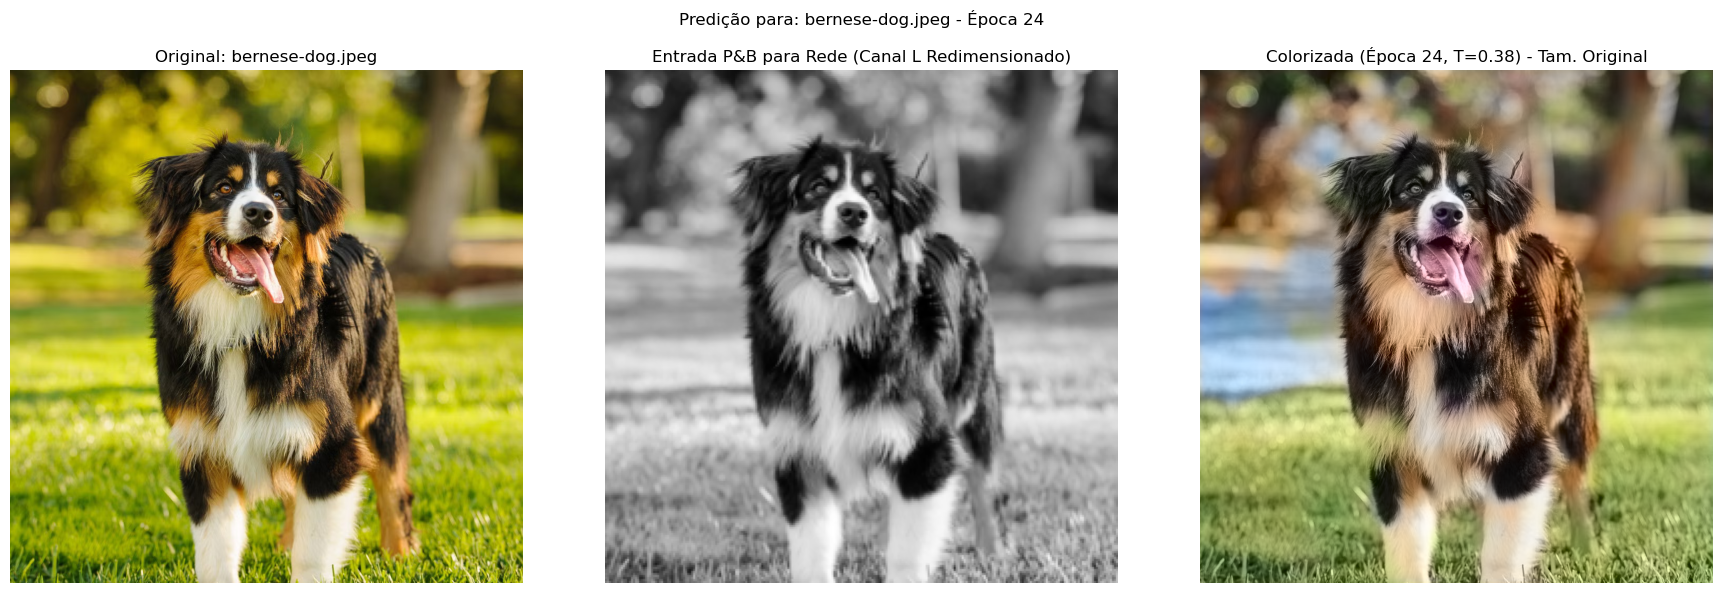

array([[[0.17908981, 0.14454094, 0.10085655],
        [0.17908981, 0.14454094, 0.10085655],
        [0.1750541 , 0.14214933, 0.09934758],
        ...,
        [0.3174334 , 0.32560685, 0.20979288],
        [0.30821356, 0.31324396, 0.20089096],
        [0.30221868, 0.3073317 , 0.19530392]],

       [[0.18314943, 0.14839163, 0.10455453],
        [0.18314943, 0.14839163, 0.10455453],
        [0.18198776, 0.14873937, 0.10567934],
        ...,
        [0.30187324, 0.3102316 , 0.19527179],
        [0.29262745, 0.29787648, 0.18637502],
        [0.28660613, 0.29194307, 0.18077588]],

       [[0.18524471, 0.15035978, 0.1059493 ],
        [0.18724409, 0.15225783, 0.10777258],
        [0.18615103, 0.15257537, 0.10895082],
        ...,
        [0.31966826, 0.33002886, 0.21180332],
        [0.31435892, 0.32149217, 0.2067045 ],
        [0.3083753 , 0.31558254, 0.20112076]],

       ...,

       [[0.3743182 , 0.42758083, 0.25692403],
        [0.38302335, 0.43633243, 0.26511994],
        [0.4370102 , 0

In [10]:
predict_from_epoch_checkpoint(
    image_path='/home/renan/Downloads/bernese-dog.jpeg',
    epoch_num=24,
    checkpoint_dir='checkpoints',
    ab_bins_path='data/ab_bins.npy'
)

## Treinamento e lógica de checkpoints

**Descrição:** Ponto de entrada principal do script.
- Define o caminho para os dados de treinamento e garante que o diretório exista.
- Chama `preprocess_colors` para gerar/verificar os arquivos `ab_bins.npy` e `color_weights.pt`.
- Procura pelo checkpoint mais recente usando `find_latest_checkpoint`.
- Inicia o processo de treinamento chamando a função `train`:
    - Se um checkpoint for encontrado, resume o treinamento a partir dele.
    - Caso contrário, inicia um novo treinamento do zero.
- Define o número total de épocas de treinamento (`num_training_epochs`).

In [10]:
# --- Execução Principal ---
if __name__ == '__main__':
    path_to_training_data = 'data/train'
    os.makedirs(path_to_training_data, exist_ok=True) # Garante que o diretório exista

    print("Verificando necessidade de pré-processamento...")
    preprocess_colors(data_train_path=path_to_training_data, force_recompute=False)

    print("\nIniciando processo de treinamento...")
    latest_chkpt = find_latest_checkpoint()
    num_training_epochs = 50 
    if latest_chkpt:
        print(f"Checkpoint encontrado: {latest_chkpt}. Resumindo treinamento.")
        train(data_path=path_to_training_data, resume_checkpoint=latest_chkpt, num_epochs=num_training_epochs)
    else:
        print("Nenhum checkpoint encontrado. Iniciando novo treinamento.")
        train(data_path=path_to_training_data, num_epochs=num_training_epochs)
    
    print("\nScript concluído.")

Verificando necessidade de pré-processamento...
Arquivos ab_bins.npy e color_weights.pt já existem. Pulando pré-processamento.

Iniciando processo de treinamento...
Checkpoint encontrado: checkpoints/epoch_11.pt. Resumindo treinamento.
Resumindo treinamento do checkpoint: checkpoints/epoch_11.pt
  Época [13/50], Batch [225/2256], Loss: 2.0335
  Época [13/50], Batch [450/2256], Loss: 3.3844
  Época [13/50], Batch [675/2256], Loss: 2.2160
  Época [13/50], Batch [900/2256], Loss: 4.8984
  Época [13/50], Batch [1125/2256], Loss: 1.8699
  Época [13/50], Batch [1350/2256], Loss: 1.7172
  Época [13/50], Batch [1575/2256], Loss: 1.8744
  Época [13/50], Batch [1800/2256], Loss: 2.0184
  Época [13/50], Batch [2025/2256], Loss: 1.6627
  Época [13/50], Batch [2250/2256], Loss: 1.4336
  Época [13/50], Batch [2256/2256], Loss: 2.1289
FIM DA ÉPOCA: 13/50, Loss Média da Época: 3.3911, Melhor Loss: 3.4205
  Novo melhor modelo salvo com loss: 3.3911
  Época [14/50], Batch [225/2256], Loss: 1.3675
  Époc

KeyboardInterrupt: 

## Observando os pixels que 'decidiram' a cor do ponto em questão

**Descrição:** Define a função `visualizar_mapa_saliencia` para gerar e exibir mapas de saliência usando a técnica de "vanilla gradients". Esta versão foi refatorada para utilizar a função `preprocess_image_for_prediction`.
- Carrega um modelo de um checkpoint especificado.
- Utiliza `preprocess_image_for_prediction` para obter o tensor L normalizado para a rede (ativando `requires_grad_()`) e imagens para exibição.
- Realiza uma passagem para frente (forward pass) para obter os logits.
- Seleciona um "score" alvo para maximização: pode ser o logit do bin de cor predito para um pixel específico, o logit de um bin de cor específico em um pixel, ou a média dos logits de um bin de cor em toda a imagem.
- Realiza uma passagem para trás (backward pass) a partir deste score até a imagem de entrada L.
- O mapa de saliência é obtido a partir da magnitude absoluta dos gradientes do tensor L de entrada.
- Exibe lado a lado: a imagem original (redimensionada que entrou no pipeline Lab), a entrada P&B (canal L) que a rede viu, e o mapa de saliência resultante (usando `cmap='hot'`).
- Permite focar em um pixel específico (`target_pixel_coords`) ou em um bin de cor específico (`target_color_bin_index`).

In [11]:
def visualizar_mapa_saliencia(
    image_path,
    model_checkpoint_path,
    target_pixel_coords=None,
    target_color_bin_index=None,
    normalize_saliency=True
):
    """
    Gera e visualiza um mapa de saliência para uma imagem de entrada,
    mostrando quais pixels de entrada mais influenciam a predição de cor.
    Utiliza a função preprocess_image_for_prediction.
    """
    if not os.path.exists(model_checkpoint_path):
        print(f"Erro: Checkpoint '{model_checkpoint_path}' não encontrado.")
        return

    # IMG_SIZE aqui é o tamanho para o qual a entrada da REDE será redimensionada
    L_tensor_normalized_for_network, _, original_pil_img_display, resized_pil_img_display = \
        preprocess_image_for_prediction(image_path, IMG_SIZE)

    if L_tensor_normalized_for_network is None:
        return # Erro já foi impresso pela função de pré-processamento

    # Mover tensor de entrada para o dispositivo e requerer gradientes
    L_tensor_normalized = L_tensor_normalized_for_network.to(DEVICE).requires_grad_()

    # Carregar o modelo
    print(f"Carregando checkpoint: {model_checkpoint_path}")
    try:
        checkpoint = torch.load(model_checkpoint_path, map_location=DEVICE)
        num_q_bins_loaded = checkpoint['num_q_bins']
        model_state_dict = checkpoint['model_state']
    except Exception as e:
        print(f"Erro ao carregar o checkpoint: {e}")
        return

    try:
        model = ColorNet(num_q_bins_loaded).to(DEVICE)
        model.load_state_dict(model_state_dict)
        model.eval()
    except Exception as e:
        print(f"Erro ao inicializar ou carregar o estado do modelo: {e}")
        return

    # Forward Pass
    predicted_logits = model(L_tensor_normalized) # Saída: (1, Q, H_rede, W_rede)

    # Seleção do alvo para o backward pass
    model.zero_grad()
    output_h, output_w = predicted_logits.shape[2], predicted_logits.shape[3] # Dimensões da saída da rede

    score_to_maximize = None
    description = ""

    if target_pixel_coords:
        py, px = target_pixel_coords
        if not (0 <= py < output_h and 0 <= px < output_w):
            print(f"Erro: Coordenadas do pixel alvo ({py},{px}) fora dos limites da saída da rede ({output_h},{output_w}).")
            return
        
        if target_color_bin_index is not None:
            if not (0 <= target_color_bin_index < num_q_bins_loaded):
                print(f"Erro: Índice do bin de cor alvo ({target_color_bin_index}) fora dos limites (0-{num_q_bins_loaded-1}).")
                return
            score_to_maximize = predicted_logits[0, target_color_bin_index, py, px]
            description = f"bin de cor {target_color_bin_index} no pixel ({py},{px})"
        else:
            target_pixel_logits = predicted_logits[0, :, py, px]
            selected_bin_index = torch.argmax(target_pixel_logits).item()
            score_to_maximize = target_pixel_logits[selected_bin_index]
            description = f"bin de cor predito com maior logit ({selected_bin_index}) no pixel ({py},{px})"
    
    elif target_color_bin_index is not None:
        if not (0 <= target_color_bin_index < num_q_bins_loaded):
            print(f"Erro: Índice do bin de cor alvo ({target_color_bin_index}) fora dos limites (0-{num_q_bins_loaded-1}).")
            return
        score_to_maximize = predicted_logits[0, target_color_bin_index, :, :].mean()
        description = f"ativação média do bin de cor {target_color_bin_index}"
    
    else: # Padrão: pixel central e bin de cor com maior logit
        py, px = output_h // 2, output_w // 2
        target_pixel_coords = (py, px) # Definir para desenhar o marcador
        target_pixel_logits = predicted_logits[0, :, py, px]
        selected_bin_index = torch.argmax(target_pixel_logits).item()
        score_to_maximize = target_pixel_logits[selected_bin_index]
        description = f"bin de cor predito com maior logit ({selected_bin_index}) no pixel central ({py},{px})"
    
    print(f"Analisando saliência para: {description}.")

    # Backward Pass
    if score_to_maximize is None: # Segurança, embora a lógica acima deva definir
        print("Erro: Score para maximização não foi definido.")
        return
    score_to_maximize.backward()

    # Obter o mapa de saliência
    saliency_map_raw = L_tensor_normalized.grad.data.abs().squeeze().cpu().numpy()

    if normalize_saliency:
        if saliency_map_raw.max() > 0:
            saliency_map = (saliency_map_raw - saliency_map_raw.min()) / (saliency_map_raw.max() - saliency_map_raw.min())
        else:
            saliency_map = np.zeros_like(saliency_map_raw)
    else:
        saliency_map = saliency_map_raw

    # Visualização
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(resized_pil_img_display) # Mostrar a imagem redimensionada que foi para Lab
    plt.title(f'Entrada Original (Redimensionada para Rede)')
    plt.axis('off')
    if target_pixel_coords:
        plt.plot(target_pixel_coords[1], target_pixel_coords[0], 'ro', markersize=10, alpha=0.7)

    # Canal L da imagem redimensionada que a rede "viu"
    lab_resized_for_bw_display = color.rgb2lab(np.array(resized_pil_img_display)).astype(np.float32)
    L_channel_for_bw_display_np = lab_resized_for_bw_display[:,:,0] / 100.0

    plt.subplot(1, 3, 2)
    plt.imshow(L_channel_for_bw_display_np, cmap='gray')
    plt.title('Entrada P&B para Rede (Canal L)')
    plt.axis('off')
    if target_pixel_coords:
        plt.plot(target_pixel_coords[1], target_pixel_coords[0], 'ro', markersize=10, alpha=0.7)

    plt.subplot(1, 3, 3)
    plt.imshow(saliency_map, cmap='hot')
    plt.title('Mapa de Saliência (Gradientes da Entrada)')
    plt.axis('off')
    if target_pixel_coords:
        plt.plot(target_pixel_coords[1], target_pixel_coords[0], 'bo', markersize=10, alpha=0.5)

    plt.suptitle(f"Mapa de Saliência para: {os.path.basename(image_path)} - Alvo: {description}")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return saliency_map

**Descrição:** Exemplos de como chamar a função `visualizar_mapa_saliencia` com diferentes parâmetros:
1. A primeira chamada usa uma imagem do dataset de treino, o checkpoint da época 24, e os alvos padrão (pixel central, bin de cor com maior logit).
2. A segunda chamada usa uma imagem externa (`Labrador_Retriever_portrait.jpg`) e os mesmos alvos padrão.
3. A terceira chamada usa outra imagem externa (`bernese-dog.jpeg`) e especifica `target_pixel_coords=[80, 40]` para focar a análise de saliência nesse pixel específico.

Carregando checkpoint: checkpoints/epoch_24.pt
Analisando saliência para: bin de cor predito com maior logit (358) no pixel central (128,128).


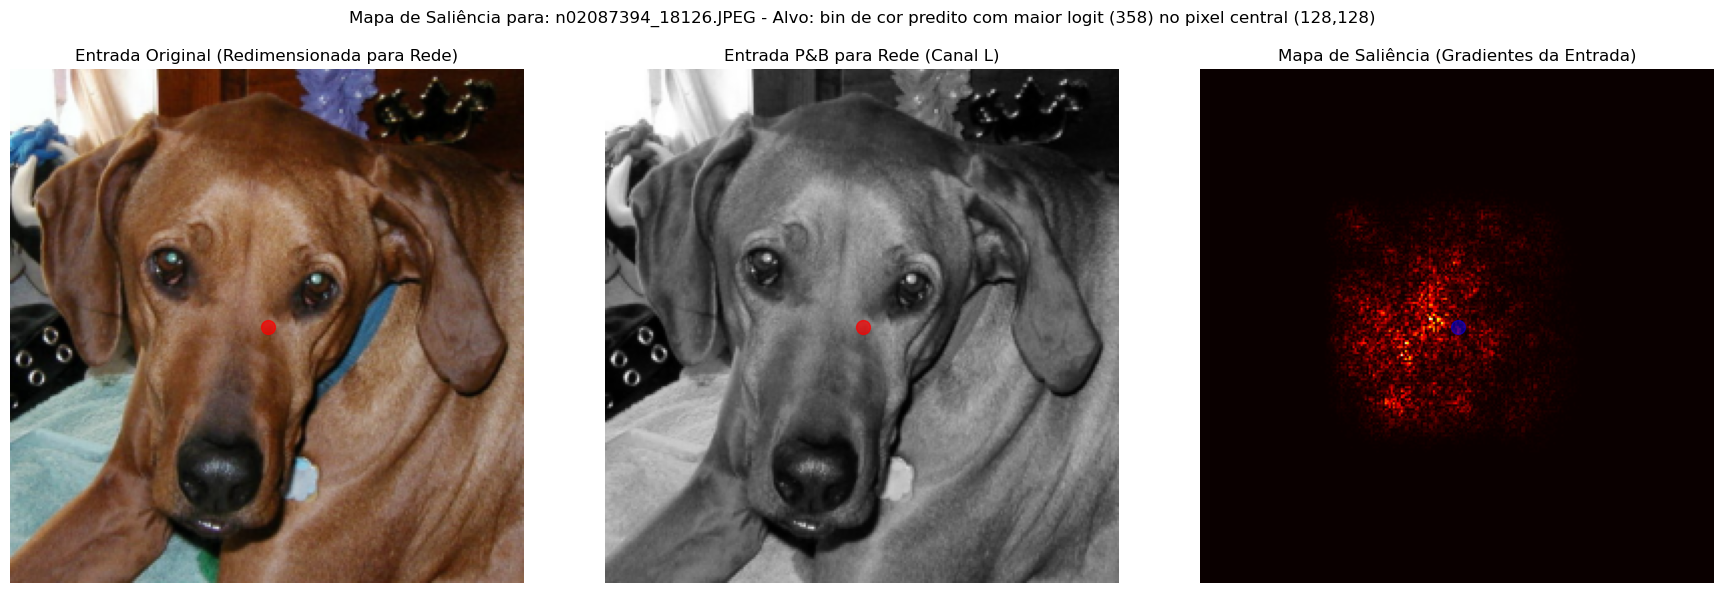

Carregando checkpoint: checkpoints/epoch_24.pt
Analisando saliência para: bin de cor predito com maior logit (264) no pixel central (128,128).


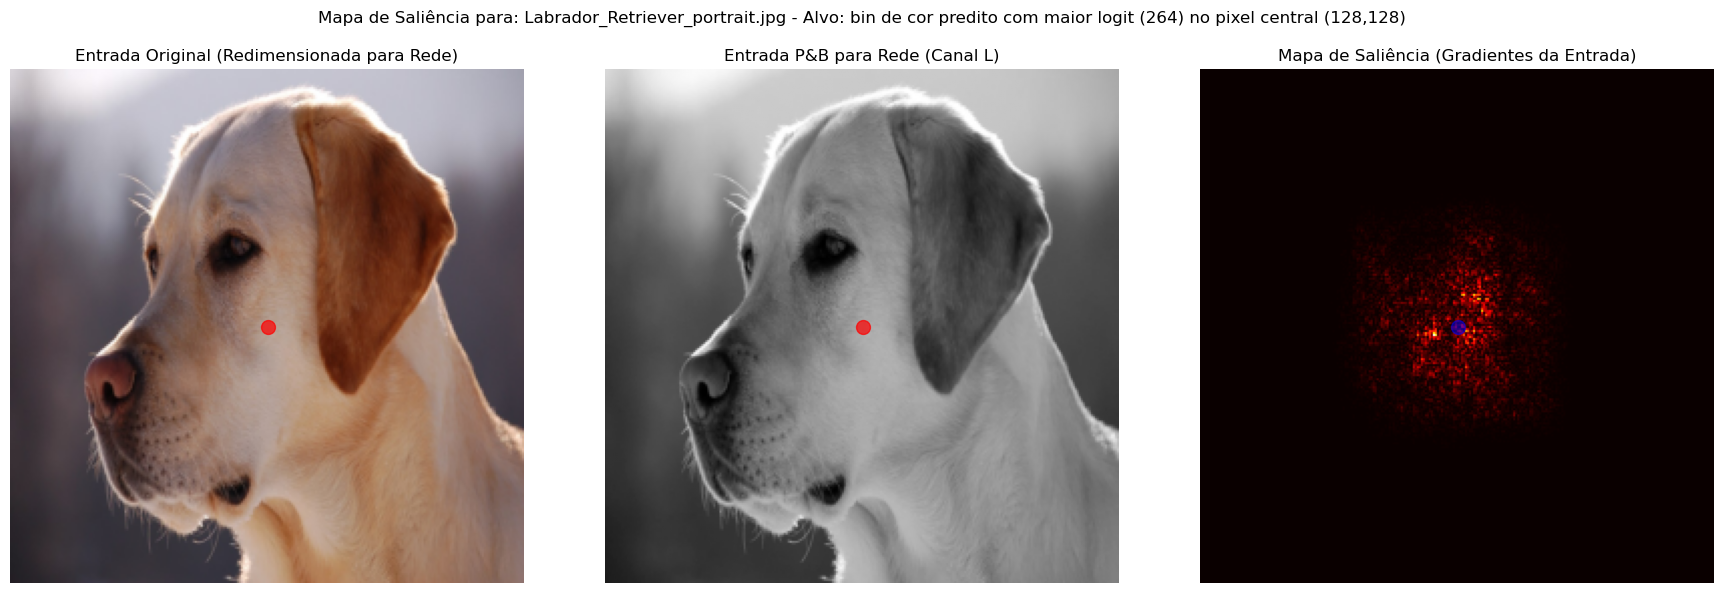

Carregando checkpoint: checkpoints/epoch_24.pt
Analisando saliência para: bin de cor predito com maior logit (357) no pixel (80,40).


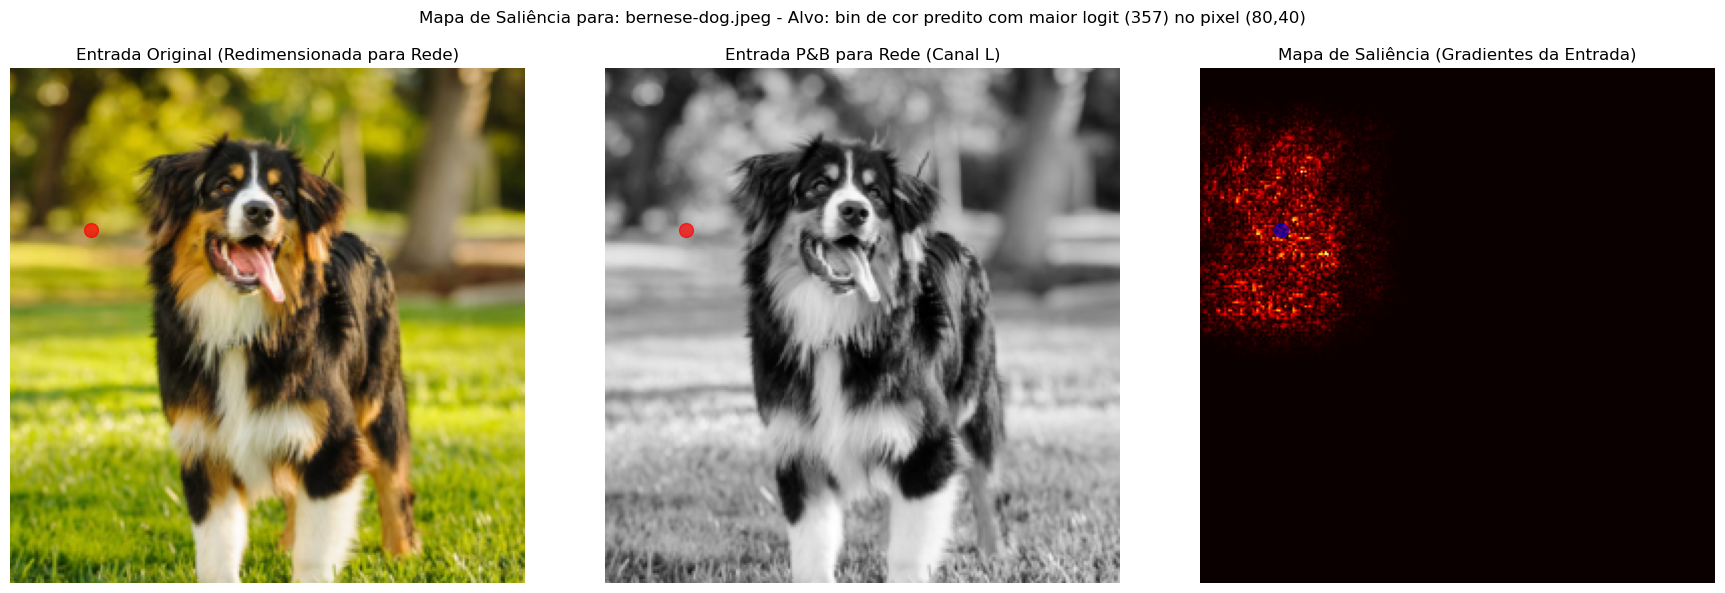

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(256, 256), dtype=float32)

In [18]:
visualizar_mapa_saliencia(
    'data/train/n02087394_18126.JPEG',
    'checkpoints/epoch_24.pt', # Caminho para o checkpoint do modelo treinado (e.g., epoch_N.pt)
    target_pixel_coords=None, # Tupla (y, x) opcional para focar em um pixel de saída
    target_color_bin_index=None, # Índice do bin de cor (0 a Q-1) opcional para focar
    normalize_saliency=True
)

visualizar_mapa_saliencia(
    '/home/renan/Downloads/Labrador_Retriever_portrait.jpg',
    'checkpoints/epoch_24.pt', # Caminho para o checkpoint do modelo treinado (e.g., epoch_N.pt)
    target_pixel_coords=None, # Tupla (y, x) opcional para focar em um pixel de saída
    target_color_bin_index=None, # Índice do bin de cor (0 a Q-1) opcional para focar
    normalize_saliency=True
)

visualizar_mapa_saliencia(
    '/home/renan/Downloads/bernese-dog.jpeg',
    'checkpoints/epoch_24.pt', # Caminho para o checkpoint do modelo treinado (e.g., epoch_N.pt)
    target_pixel_coords=[80, 40], # Tupla (y, x) opcional para focar em um pixel de saída
    target_color_bin_index=None, # Índice do bin de cor (0 a Q-1) opcional para focar
    normalize_saliency=True
)